In [1]:
import pandas as pd
import numpy as np
import nltk


In [3]:
from gensim.models import Word2Vec

In [16]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Ensure nltk dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

In [6]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')



In [8]:
# Funcția de preprocesare
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

In [9]:
# Aplică preprocesarea pe coloanele de interes
train['processed_text'] = train['text'].apply(preprocess_text)
train['processed_title'] = train['title'].apply(preprocess_text)

val['processed_text'] = val['text'].apply(preprocess_text)
val['processed_title'] = val['title'].apply(preprocess_text)

test['processed_text'] = test['text'].apply(preprocess_text)
test['processed_title'] = test['title'].apply(preprocess_text)


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combină textul și titlul
train['combined_text'] = train['processed_title'] + " " + train['processed_text']
val['combined_text'] = val['processed_title'] + " " + val['processed_text']
test['combined_text'] = test['processed_title'] + " " + test['processed_text']

In [11]:
# Pregătirea datelor pentru model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

# Transformă textele în secvențe
X_train = tokenizer.texts_to_sequences(train['combined_text'])
X_val = tokenizer.texts_to_sequences(val['combined_text'])
X_test = tokenizer.texts_to_sequences(test['combined_text'])

In [12]:
# Aplică padding
max_length = 100
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding='post')

# Pregătire etichete
y_train = train['label']
y_val = val['label']
y_test = test['label']

In [13]:
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Antrenează un model Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

In [14]:
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [22]:
# Define the CNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),  # Embedding layer
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # 1D Convolutional layer
    MaxPooling1D(pool_size=2),                              # Max pooling layer
    Dropout(0.5),                                           # Dropout layer for regularization
    Conv1D(filters=64, kernel_size=3, activation='relu'),   # Additional convolutional layer
    MaxPooling1D(pool_size=2),                              # Max pooling layer
    Dropout(0.5),
    Flatten(),                                              # Flatten to feed into dense layers
    Dense(128, activation='relu'),                          # Fully connected layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')                          # Output layer (binary classification)
])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Load the best model
from tensorflow.keras.models import load_model
best_cnn_model = load_model('best_cnn_model.h5')

# Evaluate the model
y_pred = (best_cnn_model.predict(X_test_pad) > 0.5).astype('int32')
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

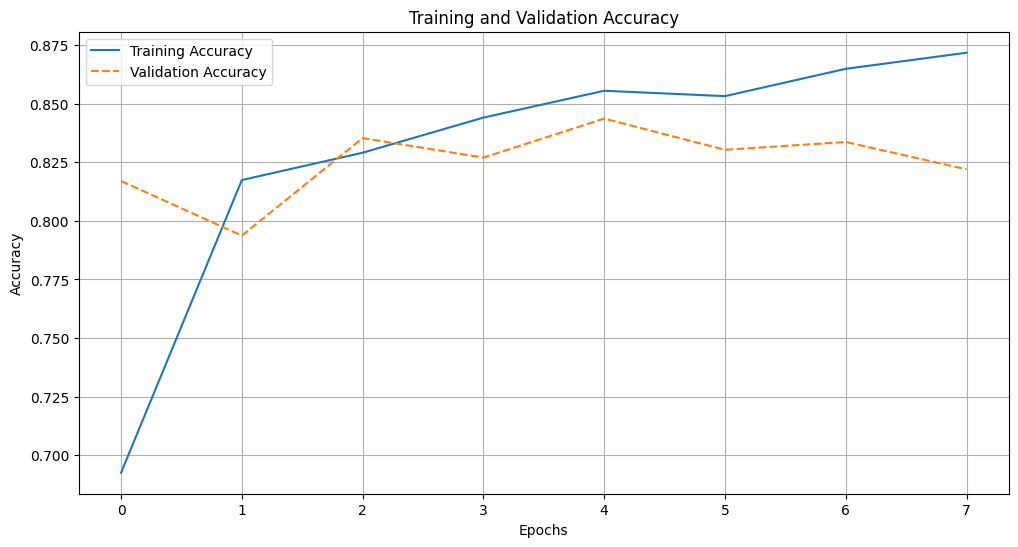

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

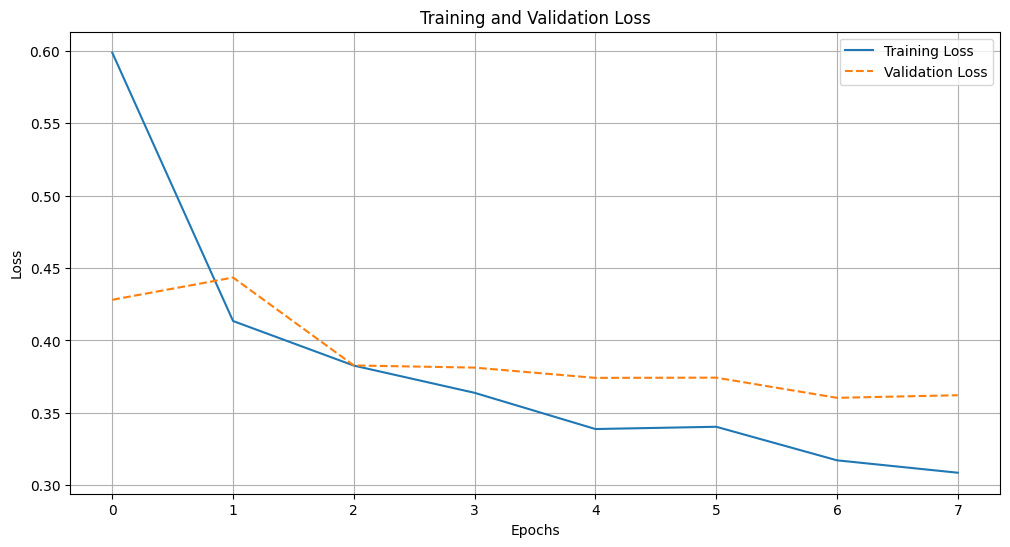

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

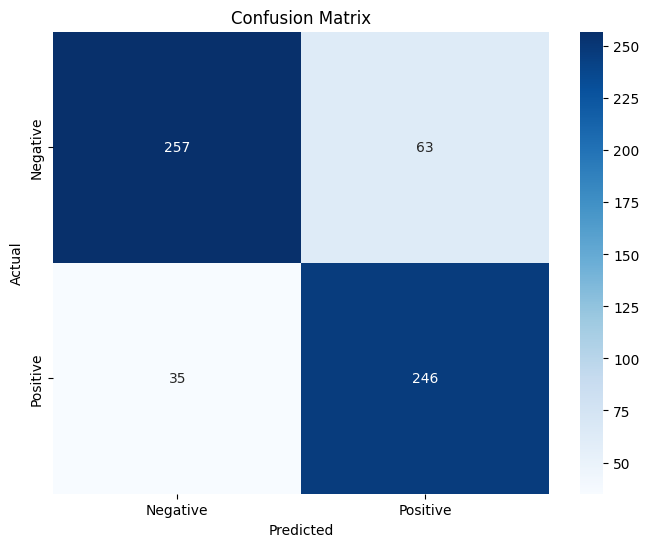

In [28]:
# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

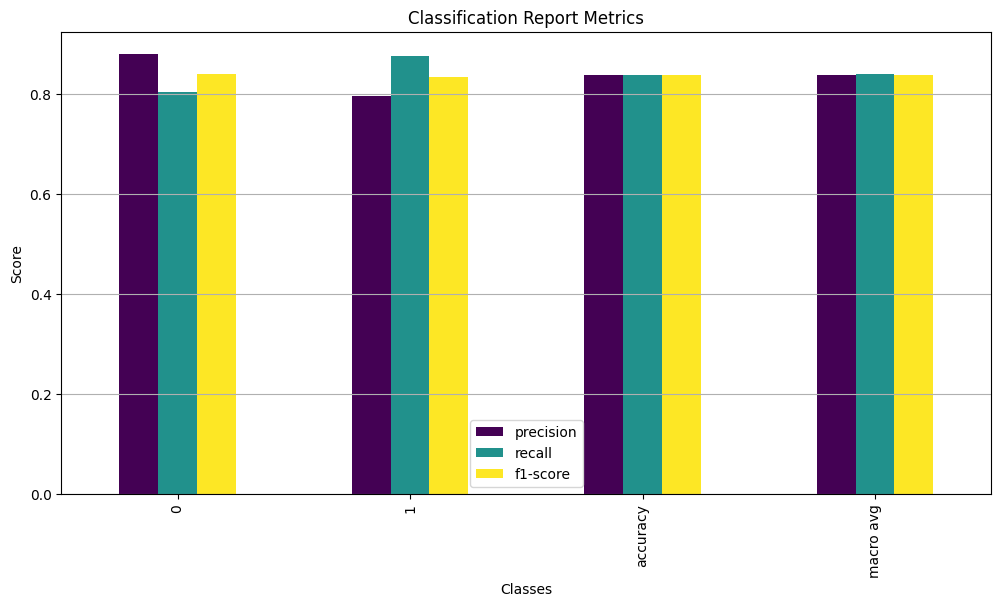

In [29]:
# 4. Classification Report Visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-1, :]  # Exclude support row

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.grid(axis='y')
plt.show()